In [1]:
%pylab notebook
from __future__ import print_function
import datacube
import pandas as pd
import xarray as xr
from datetime import date, timedelta
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio
from datacube_stats.statistics import GeoMedian

dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range

#Define temporal range
start_of_epoch = '2000-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest, # out sensors that aren't relevant for the time period
sensors = [
    'ls8', #May 2013 to present
    'ls7', #1999 to present
    'ls5' #1986 to present, full contintal coverage from 1987 onwards
        ] 


query = {
    'time': (start_of_epoch, end_of_epoch),
}

#your area of interest
lat_min = -17.968 #-17.55 down
lat_max = -17.925 #-17.50 up
lon_min = 146.127 #145.95 left
lon_max = 146.186 #146.00 right
   
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2000-01-01', '2016-12-31'), 'x': (146.127, 146.186), 'y': (-17.925, -17.968), 'crs': 'EPSG:4326'}


In [3]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [4]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}
cloud_free_threshold = 0.80  ###User modification: set cloud threshold. Default value is "0.90" or >90% image and <10% cloud cover
                        ###Scenes will not be retrieved that have less than the cloud threshold worth of image.

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
    #Discard data that does not meet the cloud_free_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [5]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 57, x: 270, y: 218)
 Coordinates:
   * time     (time) datetime64[ns] 2003-06-29T23:52:33 ...
   * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
   * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
 Data variables:
     green    (time, y, x) float64 420.0 478.0 478.0 478.0 478.0 420.0 420.0 ...
     red      (time, y, x) float64 45.0 93.0 93.0 93.0 93.0 93.0 93.0 93.0 ...
     nir      (time, y, x) float64 74.0 74.0 132.0 74.0 74.0 74.0 74.0 74.0 ...
     swir1    (time, y, x) float64 28.0 10.0 10.0 70.0 28.0 10.0 10.0 10.0 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 135, x: 270, y: 218)
 Coordinates:
   * time     (time) datetime64[ns] 2000-01-21T00:09:11.500000 ...
   * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
   * x        (x) float64 1.493e+

In [6]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted 
#by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [7]:
#Check that the concatenation worked

nbar_clean

<xarray.Dataset>
Dimensions:  (time: 226, x: 270, y: 218)
Coordinates:
  * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
  * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
  * time     (time) datetime64[ns] 2000-01-21T00:09:11.500000 ...
Data variables:
    green    (time, y, x) float64 362.0 345.0 345.0 345.0 380.0 362.0 362.0 ...
    red      (time, y, x) float64 118.0 118.0 103.0 103.0 118.0 148.0 133.0 ...
    nir      (time, y, x) float64 87.0 87.0 87.0 87.0 87.0 87.0 87.0 87.0 ...
    swir1    (time, y, x) float64 36.0 57.0 36.0 36.0 78.0 57.0 57.0 57.0 ...
    product  (time) <U3 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1493450.00|\n| 0.00,-25.00,-1996550.00|\n| 0.00,...

In [10]:
# product_time = nbar_clean[['time', 'product']].to_dataframe() #Add time and product to dataframe
# product_time.index = product_time.index + pd.Timedelta(hours=10) #Roughly convert to local time
# product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

In [11]:
start_of_event= '2011-01-26'
end_of_event= '2011-02-06'

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime

In [9]:
# event_dates=pd.DataFrame()
# delta = end_of_event - start_of_event
# for i in range(delta.days + 1):
#     date=start_of_event + timedelta(days=i)
#     date=pd.DataFrame([date],index=None)
#     event_dates=event_dates.append(date)
# event_dates.columns=['date']
# event_dates=event_dates.set_index('date',drop=False)
# event_dates.index=event_dates.index.map(lambda t: t.strftime('%Y-%m-%d'))
# event_dates['test']=1

In [12]:
# start_of_interest= start_of_event+datetime.timedelta(days=-500)
# end_of_interest= end_of_event+datetime.timedelta(days=200)

# interest_dates=pd.DataFrame()
# delta = end_of_interest - start_of_interest
# for i in range(delta.days + 1):
#     date=start_of_interest + timedelta(days=i)
#     date=pd.DataFrame([date],index=None)
#     interest_dates=interest_dates.append(date)

# interest_dates.columns=['date']
# interest_dates=interest_dates.set_index('date',drop=False)
# interest_dates.index=interest_dates.index.map(lambda t: t.strftime('%Y-%m-%d'))
# interest_dates['test']=1

In [ ]:
# subset_data = pd.merge(interest_dates, product_time, left_index=True,#left_on= 'date', 
#                        right_index=True, how='inner') #Match dates and merge

In [13]:
# #create widget that enables interaction with hydrograph
# w = widgets.HTML("Event information appears here when you click on the figure")
# def callback(event):
#     global date_int, devent
#     devent = event
#     date_int = event.xdata
# #     discharge_int= event.ydata
#     time_int_ = time_int.astype(datetime64[D])
#     w.value = 'time_int: {}'.format(time_int)

# #Set up plot
# fig = plt.figure(figsize=(5,5)) #Edit size of plot ##User should format as required
# fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
# plt.title('Interactive graph', size=14) #Plot title ##User should format if required
# plt.show() #Plot setup
# display(w) #Plot setup
# plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.15) #Set border dimensions  ##User should format if required
# fig.patch.set_facecolor('white') #Make border white ##User should format if required
# fig.patch.set_alpha(0.99) #Make border white ##User should format if required

# matplotlib.pyplot.plot_date(interest_dates.date,interest_dates.test, 'g.', 
#                             label= 'blah') #plot all discharge values ##User should format series if required
# matplotlib.pyplot.plot_date(event_dates.date,event_dates.test, 'b.', 
#                             label= 'blah') #plot all discharge values ##User should format series if required
# matplotlib.pyplot.plot_date(subset_data.date,subset_data.test, 'r.', markersize=20,
#                             label= 'blah') #plot all discharge values ##User should format series if required


# #Axis details
# # firstyear =  min_date ###User modification: set period of interest use "min_date" variable for automatic scaling
# # lastyear = max_date ###User modification: set period of interest use "max_date" variable for automatic scaling
# # plt.axis([firstyear , lastyear ,min_flow, max_flow], 'tight') #Set axis
# plt.yticks([]) #format size of date labels ##User should format if required
# plt.xticks(rotation=45,size=12) #Rotate and format size of date labels ##User should format if required
# plt.xlabel('Date', size=14) #Set X label
# plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=14) #Set legend location on plot ##User should format if required


In [ ]:
# date_int
# time_slice = matplotlib.dates.num2date(date_int).date()
# time_slice=format(time_slice,'%Y-%m-%d %H:%M:%S')
# time_slice= str(time_slice) #Convert to string
# time_slice=datetime.datetime.strptime(time_slice,'%Y-%m-%d  %H:%M:%S') #Convert to datetime
# time_slice

In [16]:
#Prepare imagery
rgb = nbar_clean.sel(time =end_of_event, method = 'pad').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


In [35]:
(nbar_clean.sel(time =end_of_event, method = 'pad').time)

<xarray.DataArray 'time' ()>
array(1281571716500000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-08-12T00:08:36.500000
Attributes:
    units:    seconds since 1970-01-01 00:00:00

<IPython.core.display.Javascript object>


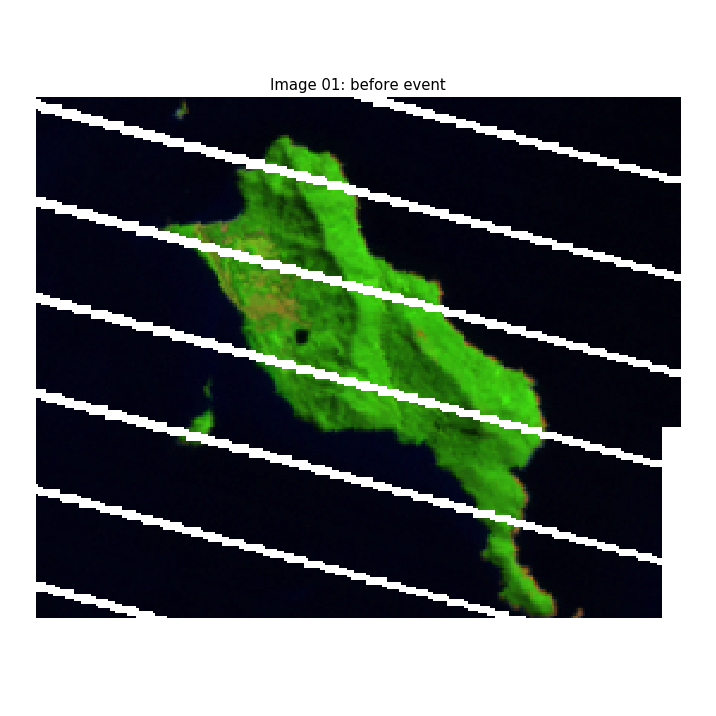

In [36]:
#Create small area image for the event of interest

fig = plt.figure(figsize =(8,8)) #Edit size of plot ##User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99)#Make border white ##User should format if required
plt.axis('off')#remove axis ##User should delete code if required
plt.title('Image 01: before event')
plt.imshow(scaled, interpolation = 'nearest')
plt.show() #Create plot

In [38]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
ndvi01= ndvi.sel(time =end_of_event, method = 'pad')
ndvi01

<xarray.DataArray (y: 218, x: 270)>
array([[-0.610256, -0.560694, -0.118812, ...,  0.119497,  0.119497,  0.29927 ],
       [      nan,       nan, -0.610256, ..., -0.415385, -0.016575, -0.016575],
       [      nan,       nan,       nan, ..., -0.415385, -0.016575, -0.016575],
       ..., 
       [-0.016575, -0.415385, -0.5     , ...,       nan,       nan,       nan],
       [-0.123153, -0.296296, -0.415385, ...,       nan,       nan,       nan],
       [-0.563218, -0.5     , -0.415385, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
  * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
    time     datetime64[ns] 2010-08-12T00:08:36.500000

<IPython.core.display.Javascript object>


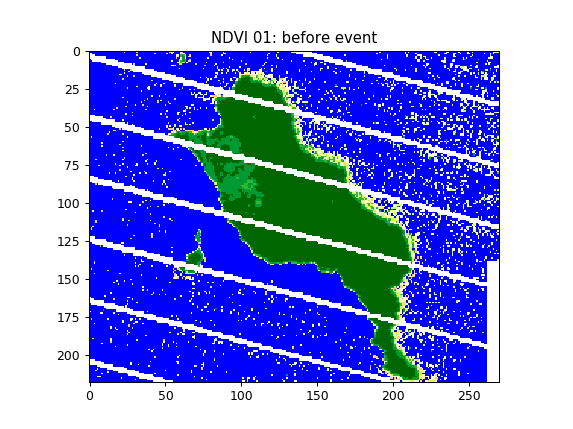

In [41]:
#This controls the colour maps used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

fig = plt.figure()
plt.title('NDVI 01: before event')
plt.imshow(ndvi01,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm)

# After Event

In [43]:
# #create widget that enables interaction with hydrograph
# w = widgets.HTML("Event information appears here when you click on the figure")
# def callback(event):
#     global date_int2, devent
#     devent = event
#     date_int2 = event.xdata
# #     discharge_int= event.ydata
#     date_int_ = date_int2.astype(datetime64[D])
#     w.value = 'time_int: {}'.format(time_int)

# #Set up plot
# fig = plt.figure(figsize=(5,5)) #Edit size of plot ##User should format as required
# fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
# plt.title('Interactive graph', size=14) #Plot title ##User should format if required
# plt.show() #Plot setup
# display(w) #Plot setup
# plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.15) #Set border dimensions  ##User should format if required
# fig.patch.set_facecolor('white') #Make border white ##User should format if required
# fig.patch.set_alpha(0.99) #Make border white ##User should format if required

# matplotlib.pyplot.plot_date(interest_dates.date,interest_dates.test, 'g.', 
#                             label= 'blah') #plot all discharge values ##User should format series if required
# matplotlib.pyplot.plot_date(event_dates.date,event_dates.test, 'b.', 
#                             label= 'blah') #plot all discharge values ##User should format series if required
# matplotlib.pyplot.plot_date(subset_data.date,subset_data.test, 'r.', markersize=20,
#                             label= 'blah') #plot all discharge values ##User should format series if required


# #Axis details
# # firstyear =  min_date ###User modification: set period of interest use "min_date" variable for automatic scaling
# # lastyear = max_date ###User modification: set period of interest use "max_date" variable for automatic scaling
# # plt.axis([firstyear , lastyear ,min_flow, max_flow], 'tight') #Set axis
# plt.yticks([]) #format size of date labels ##User should format if required
# plt.xticks(rotation=45,size=12) #Rotate and format size of date labels ##User should format if required
# plt.xlabel('Date', size=14) #Set X label
# plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=14) #Set legend location on plot ##User should format if required

In [44]:
# time_slice2 = matplotlib.dates.num2date(date_int2).date()
# time_slice2=format(time_slice2,'%Y-%m-%d %H:%M:%S')
# time_slice2= str(time_slice2) #Convert to string
# time_slice2=datetime.datetime.strptime(time_slice2,'%Y-%m-%d  %H:%M:%S') #Convert to datetime
# time_slice2

In [48]:
#Prepare imagery
rgb02 = nbar_clean.sel(time =end_of_event, method = 'backfill').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb02 = rgb02.astype('double')
clipped_visible02 = rgb02.where(rgb02<fake_saturation).fillna(fake_saturation)
max_val02 = clipped_visible02.max(['y', 'x'])
scaled02 = (clipped_visible02 / max_val02)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


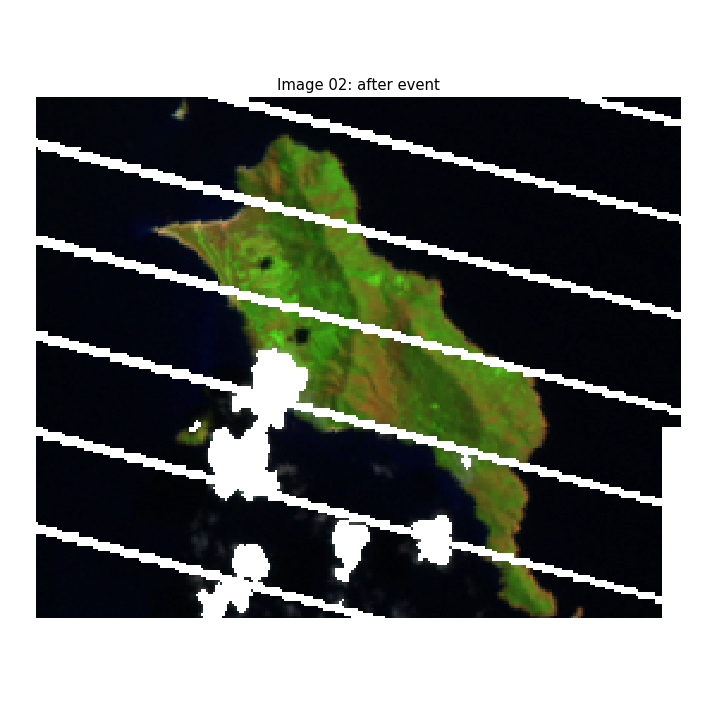

In [49]:
#Create small area image for the event of interest

fig = plt.figure(figsize =(8,8)) #Edit size of plot ##User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99)#Make border white ##User should format if required
plt.axis('off')#remove axis ##User should delete code if required
plt.title('Image 02: after event')
plt.imshow(scaled02, interpolation = 'nearest')
#            extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
#                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.show() #Create plot

In [51]:
ndvi02= ndvi.sel(time =end_of_event, method = 'pad')

<IPython.core.display.Javascript object>


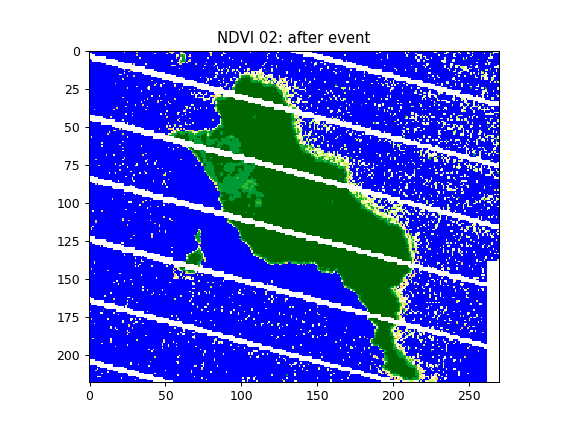

In [52]:
fig = plt.figure()
plt.title('NDVI 02: after event' )
plt.imshow(ndvi02,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm)

# Change in vegetation before/after cyclone

In [62]:
ndvi01

<xarray.DataArray (y: 218, x: 270)>
array([[-0.610256, -0.560694, -0.118812, ...,  0.119497,  0.119497,  0.29927 ],
       [      nan,       nan, -0.610256, ..., -0.415385, -0.016575, -0.016575],
       [      nan,       nan,       nan, ..., -0.415385, -0.016575, -0.016575],
       ..., 
       [-0.016575, -0.415385, -0.5     , ...,       nan,       nan,       nan],
       [-0.123153, -0.296296, -0.415385, ...,       nan,       nan,       nan],
       [-0.563218, -0.5     , -0.415385, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
  * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
    time     datetime64[ns] 2010-08-12T00:08:36.500000

In [65]:
ndvi_change= ndvi02-ndvi01
# ndvi_change=(((ndvi_change-np.amin(ndvi_change))/(np.amax(ndvi_change)-np.amin(ndvi_change)))*100)

In [66]:
ndvi_change

<xarray.DataArray (y: 218, x: 270)>
array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [ nan,  nan,   0., ...,   0.,   0.,   0.],
       [ nan,  nan,  nan, ...,   0.,   0.,   0.],
       ..., 
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan]])
Coordinates:
  * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
  * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
    time     datetime64[ns] 2010-08-12T00:08:36.500000

<IPython.core.display.Javascript object>


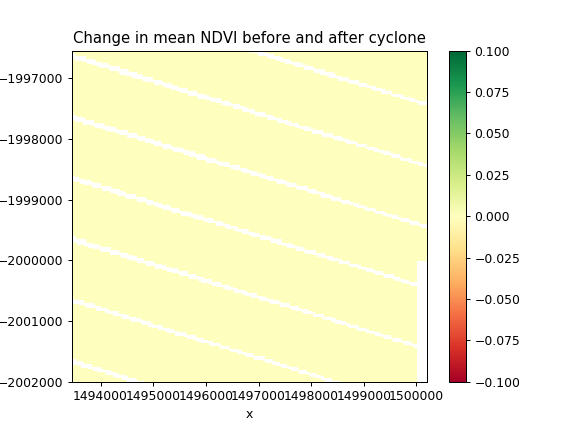

In [67]:
fig = plt.figure()
ndvi_change.plot(cmap = 'RdYlGn')
plt.title('Change in mean NDVI before and after cyclone')
plt.show()

In [ ]:
#edit dates to correct format
#match dates with imagery
#create figure that shows dates for images and event of interest
#click on figure and bring back NDVI figure for date before and date after
# figure that shows the difference between before and after

1) choose location
2) choose date (s)
3) show either side of cyclone
4) NDVI
5) draw box/quantify change